# Import Library

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import metrics
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Download and Extract Dataset

In [5]:
base_dir = 'image-model-2/'


In [6]:
IMAGE_SIZE = [224, 224]
mobile_net = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
for layer in mobile_net.layers:
    layer.trainable = False

In [8]:
folders = glob('image-model-2/*')

In [9]:
# our layers - you can add more if you want
x = Flatten()(mobile_net.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
os.listdir(base_dir)

['bopeng', 'jerawat', 'normal']

In [11]:
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split("/")[-1])
        file_name.append(name)


In [12]:
df = pd.DataFrame({"path": full_path, "file_name": file_name, "tag": tag})
df.groupby(["tag"]).size()


tag
bopeng     476
jerawat    480
normal     480
dtype: int64

In [13]:
df.head(10)

,path,file_name,tag
0,image-model-2/bopeng\b_0_10.jpg,b_0_10.jpg,bopeng
1,image-model-2/bopeng\b_0_1025.jpg,b_0_1025.jpg,bopeng
2,image-model-2/bopeng\b_0_1034.jpg,b_0_1034.jpg,bopeng
3,image-model-2/bopeng\b_0_1055.jpg,b_0_1055.jpg,bopeng
4,image-model-2/bopeng\b_0_1060.jpg,b_0_1060.jpg,bopeng
5,image-model-2/bopeng\b_0_1072.jpg,b_0_1072.jpg,bopeng
6,image-model-2/bopeng\b_0_1089.jpg,b_0_1089.jpg,bopeng
7,image-model-2/bopeng\b_0_1140.jpg,b_0_1140.jpg,bopeng
8,image-model-2/bopeng\b_0_1162.jpg,b_0_1162.jpg,bopeng
9,image-model-2/bopeng\b_0_1171.jpg,b_0_1171.jpg,bopeng


In [14]:
X = df["path"]
y = df["tag"]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)

In [16]:
data_train = pd.DataFrame({"path": X_train, "tag": y_train, "set": "train"})
data_test = pd.DataFrame({"path": X_test, "tag": y_test, "set": "test"})

In [17]:
print("train size", len(data_train))
print("test size", len(data_test))

train size 1148
test size 288


In [18]:
# Melihat proporsi training dan validation set
df_all = data_train.append([data_test]).reset_index(drop=1)
print(df_all.groupby(["set", "tag"]).size(), "\n")

# Cek sample data
df_all.sample(3)

set    tag    
test   bopeng      96
       jerawat     96
       normal      96
train  bopeng     380
       jerawat    384
       normal     384
dtype: int64 



C:\Users\User\AppData\Local\Temp\ipykernel_18396\3928688440.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = data_train.append([data_test]).reset_index(drop=1)


,path,tag,set
628,image-model-2/normal\n_0_6114.jpg,normal,train
804,image-model-2/jerawat\j_0_3308.jpg,jerawat,train
53,image-model-2/normal\n_0_3032.jpg,normal,train


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    # rotation_range=40,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # fill_mode="nearest",
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    # rotation_range=40,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # fill_mode="nearest",
)


In [20]:
train_generator = train_datagen.flow_from_dataframe(
        data_train,
        x_col="path",
        y_col="tag",
        target_size=(224, 224),
        class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
        data_test,
        x_col="path",
        y_col="tag",
        target_size=(224, 224),
        class_mode="categorical"
)

Found 1148 validated image filenames belonging to 3 classes.
Found 288 validated image filenames belonging to 3 classes.


# Building Model

In [21]:
model = Model(inputs=mobile_net.input, outputs=prediction)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [23]:
model.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [24]:
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=5,
      validation_data=test_generator,
      validation_steps=len(test_generator),
)


Epoch 1/5
36/36 [==============================] - 20s 521ms/step - loss: 1.1508 - accuracy: 0.8920 - val_loss: 0.1154 - val_accuracy: 0.9861
Epoch 2/5
36/36 [==============================] - 17s 479ms/step - loss: 0.0254 - accuracy: 0.9939 - val_loss: 0.1361 - val_accuracy: 0.9896
Epoch 3/5
36/36 [==============================] - 17s 483ms/step - loss: 0.0119 - accuracy: 0.9983 - val_loss: 0.0734 - val_accuracy: 0.9965
Epoch 4/5
36/36 [==============================] - 18s 504ms/step - loss: 9.0368e-04 - accuracy: 0.9991 - val_loss: 0.1100 - val_accuracy: 0.9896
Epoch 5/5
36/36 [==============================] - 19s 522ms/step - loss: 4.3096e-05 - accuracy: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9896


# Model Accuracy

In [25]:
test_loss, test_acc = model.evaluate(test_generator)
print("\naccuracy:", test_acc, "  loss: ", test_loss)


9/9 [==============================] - 4s 410ms/step - loss: 0.1074 - accuracy: 0.9896

accuracy: 0.9895833134651184   loss:  0.10735669732093811


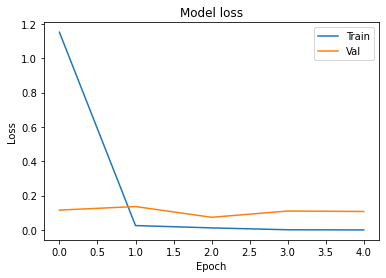

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

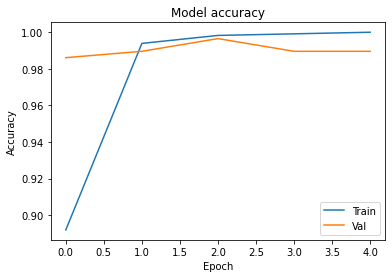

In [27]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

# Making Prediction

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


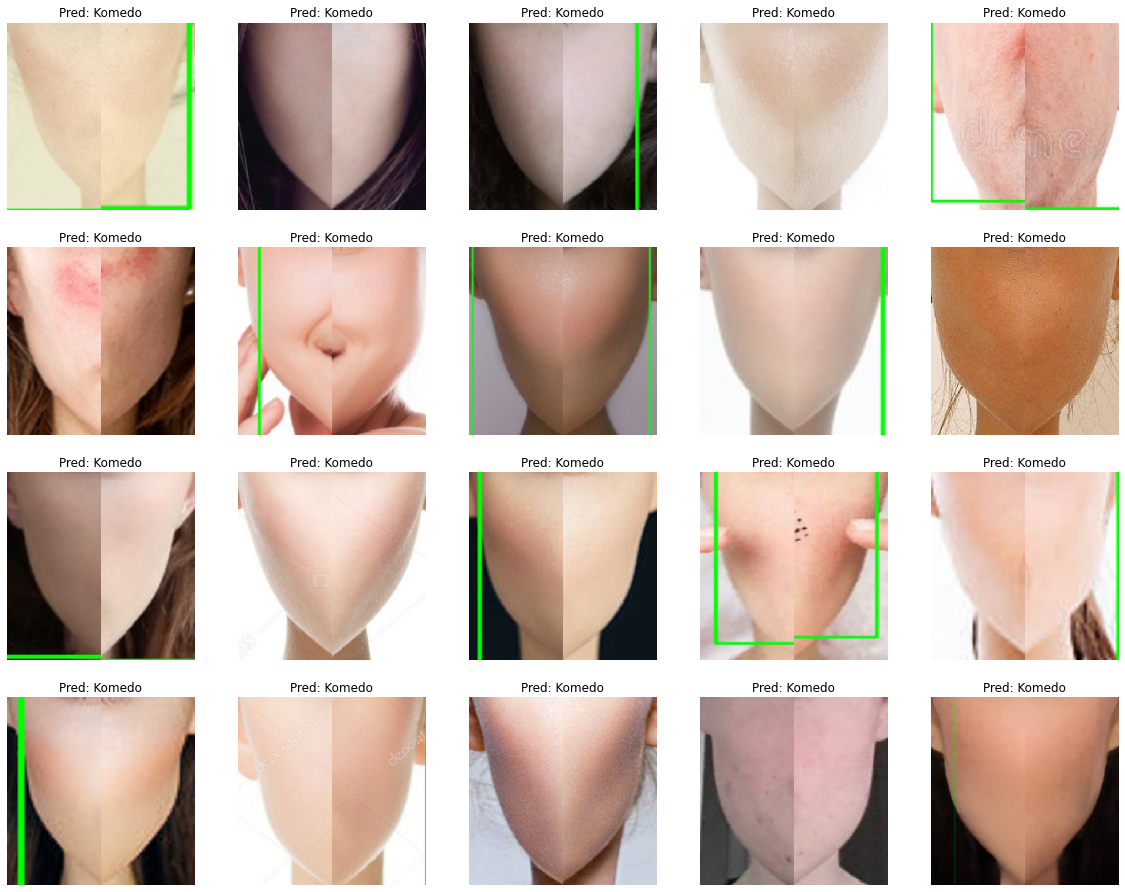

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

m = 1
columns = 5
rows = 5
directory = 'image-test-cropped/test-model-2'
pred_labels = ""
# iterate over files in
# that directory
fig = plt.figure(figsize=(20, 20))
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img = image.load_img(f, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        classes = np.argmax(classes, axis=1)
        print(classes)
        if classes==0:
            pred_labels = 'Bopeng'
        elif classes==1:
            pred_labels = 'Jerawat'
        else:
            pred_labels = 'Komedo'
            
        fig.add_subplot(rows, columns, m)
        plt.imshow(img)
        plt.axis('Off')
        plt.title("Pred: " + pred_labels)
        m += 1

In [29]:
preds = np.round(model.predict(test_generator), 0)
print(preds)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1.

In [30]:
num_classes = len(test_generator.class_indices)
test_labels = test_generator.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [31]:
faces = ['bopeng', 'jerawat', 'komedo']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=faces)
print(classification_metrics)

              precision    recall  f1-score   support

      bopeng       0.31      0.32      0.32        96
     jerawat       0.30      0.29      0.30        96
      komedo       0.28      0.28      0.28        96

   micro avg       0.30      0.30      0.30       288
   macro avg       0.30      0.30      0.30       288
weighted avg       0.30      0.30      0.30       288
 samples avg       0.30      0.30      0.30       288



# Save the Model

In [30]:
# MODEL_BASE_PATH = "model"
# PROJECT_NAME = "ausion_project"
# SAVE_MODEL_NAME = "ausion.h5"
# save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
# if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
#     os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

# print("Saving Model At {}...".format(save_model_path))
# model.save(save_model_path)
